In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import os
import gc
from IPython.core.display import display, HTML, display_pretty
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import lightgbm as lgb
from imblearn.datasets import make_imbalance
os.chdir('/home/sambeet/data/dsg/')

In [2]:
trade = pd.read_csv('Trade.csv',parse_dates=['TradeDateKey'])
trade['CustomerInterest'] = 1
trade['BuySell'] = trade['BuySell'].astype('category')
trade['TradeStatus'] = trade['TradeStatus'].astype('category')
trade['CustomerInterest'] = trade['CustomerInterest'].astype('bool')
trade['year'] = trade.TradeDateKey.dt.year
trade['weekofyear'] = trade.TradeDateKey.dt.weekofyear
trade.drop(['TradeDateKey','NotionalEUR','Price','TradeStatus'],axis=1,inplace=True)
trade.head()
#trade = trade.groupby(['CustomerIdx','IsinIdx','BuySell','year','month','weekofyear'])['CustomerInterest'].sum().reset_index()
#trade['CustomerInterest'] = trade.CustomerInterest >= 1

,CustomerIdx,IsinIdx,BuySell,CustomerInterest,year,weekofyear
0,2789,8478,Sell,True,2016,49
1,2574,14562,Buy,True,2017,13
2,2574,4747,Buy,True,2017,16
3,2574,9885,Sell,True,2017,10
4,2574,8885,Buy,True,2016,46


In [3]:
yearlist = list(np.unique(trade.year))
weekofyearlist = list(np.unique(trade.weekofyear))
for year in yearlist:
    print year
    for weekofyear in weekofyearlist:
        if year == 2017 and weekofyear == 53:
            continue
        elif year == 2018 and weekofyear >= 17:
            continue
        else:
            print weekofyear
            temp = trade[(trade.year == year) & (trade.weekofyear == weekofyear)].copy()
            temp.drop(['BuySell'],axis=1,inplace=True)
            temp.drop_duplicates(inplace=True)
            temp_buy = temp.copy()
            temp_buy['BuySell'] = 'Buy'
            temp['BuySell'] = 'Sell'
            temp = pd.concat([temp,temp_buy],axis=0)
            temp['year'] = year
            temp['weekofyear'] = weekofyear
            temp['CustomerInterest'] = False
            trade = pd.concat([trade,temp],axis=0)

2016
1


/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
2017
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
2018
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [4]:
trade.shape

(19162175, 6)

In [5]:
del temp
gc.collect()

109

In [6]:
trade = trade.groupby(['CustomerIdx','IsinIdx','BuySell','year','weekofyear'])['CustomerInterest'].sum().reset_index()
trade['CustomerInterest'] = trade.CustomerInterest >= 1
trade.head()

,CustomerIdx,IsinIdx,BuySell,year,weekofyear,CustomerInterest
0,0,16471,Buy,2017,20,True
1,0,16471,Sell,2017,20,False
2,0,16499,Buy,2017,23,True
3,0,16499,Sell,2017,23,False
4,0,20601,Buy,2017,24,True


In [7]:
trade.shape

(12400154, 6)

In [8]:
customer = pd.read_csv('Customer.csv')
categorical_columns = ['Sector','Subsector','Region','Country']
for col in categorical_columns:
    customer[col] = customer[col].astype('category')
    print 'Transforming {}...'.format(col)
    encoder = LabelEncoder()
    encoder.fit(customer[col].astype(str))
    customer[col] = encoder.transform(customer[col].astype(str))

bond = pd.read_csv('Isin.csv',parse_dates=['ActualMaturityDateKey', 'IssueDateKey'])
categorical_columns = ['Seniority','Currency','ActivityGroup','Region','Activity',
       'RiskCaptain','Owner','CompositeRating','IndustrySector','IndustrySubgroup','MarketIssue','CouponType']
for col in categorical_columns:
    bond[col] = bond[col].astype('category')
    print 'Transforming {}...'.format(col)
    encoder = LabelEncoder()
    encoder.fit(bond[col].astype(str))
    bond[col] = encoder.transform(bond[col].astype(str))

customer = customer.rename({'Region':'CustomerRegion'},axis=1)
bond = bond.rename({'Region':'BondRegion'},axis=1)
encoder = LabelEncoder()
encoder.fit(trade['BuySell'].astype(str))    
trade['BuySell'] = encoder.transform(trade['BuySell'].astype(str))

Transforming Sector...
Transforming Subsector...
Transforming Region...
Transforming Country...
Transforming Seniority...
Transforming Currency...
Transforming ActivityGroup...
Transforming Region...
Transforming Activity...
Transforming RiskCaptain...
Transforming Owner...
Transforming CompositeRating...
Transforming IndustrySector...
Transforming IndustrySubgroup...
Transforming MarketIssue...
Transforming CouponType...


In [9]:
gc.collect()
trade = trade.merge(customer,on=['CustomerIdx'],how='left')
trade = trade.merge(bond,on=['IsinIdx'],how='left')

In [10]:
trade.head()

,CustomerIdx,IsinIdx,BuySell,year,weekofyear,CustomerInterest,Sector,Subsector,CustomerRegion,Country,...,BondRegion,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType
0,0,16471,0,2017,20,True,0,24,1,34,...,1,2,1,0,11,7,247,5,5.500000e+08,0
1,0,16471,1,2017,20,False,0,24,1,34,...,1,2,1,0,11,7,247,5,5.500000e+08,0
2,0,16499,0,2017,23,True,0,24,1,34,...,1,2,1,0,9,7,247,5,1.500000e+09,0
3,0,16499,1,2017,23,False,0,24,1,34,...,1,2,1,0,9,7,247,5,1.500000e+09,0
4,0,20601,0,2017,24,True,0,24,1,34,...,1,2,1,0,7,7,247,5,2.500000e+08,0


In [11]:
trade.CustomerInterest.mean()

0.5050525985403085

In [12]:
categorical_to_be_transformed = ['BuySell','Sector','Subsector','CustomerRegion', 'Country','Seniority','Currency',
                                 'ActivityGroup', 'BondRegion', 'Activity', 'RiskCaptain', 'Owner', 
                                 'CompositeRating', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue','CouponType']
categorical_holdings = categorical_to_be_transformed + ['year','CustomerIdx','IsinIdx']#,'weekofyear']
#categorical.remove('BuySell')
predictors_holdings = list(trade.columns)
#predictors.remove('TradeDateKey')
#predictors.remove('IsinIdx')
#predictors.remove('Price')
predictors_holdings.remove('CustomerInterest')
#predictors.remove('BuySell')
predictors_holdings.remove('ActualMaturityDateKey')
predictors_holdings.remove('IssueDateKey')
#predictors.remove('TradeStatus')
#predictors.remove('NotionalEUR')
#predictors.remove('BondPrice')
#predictors.remove('Yield')
#predictors.remove('ZSpread')
#predictors.remove('day')
#predictors.remove('weekday')
predictors_holdings.remove('TickerIdx')
predictors_holdings.remove('weekofyear')
#predictors_holdings.remove('month')
#predictors.remove('CustomerIdx')

target_holdings = 'CustomerInterest'
print(predictors_holdings,categorical_holdings,len(predictors_holdings),trade.shape[0])

(['CustomerIdx', 'IsinIdx', 'BuySell', 'year', 'Sector', 'Subsector', 'CustomerRegion', 'Country', 'Seniority', 'Currency', 'ActivityGroup', 'BondRegion', 'Activity', 'RiskCaptain', 'Owner', 'CompositeRating', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'IssuedAmount', 'CouponType'], ['BuySell', 'Sector', 'Subsector', 'CustomerRegion', 'Country', 'Seniority', 'Currency', 'ActivityGroup', 'BondRegion', 'Activity', 'RiskCaptain', 'Owner', 'CompositeRating', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'CouponType', 'year', 'CustomerIdx', 'IsinIdx'], 21, 12400154)


In [17]:
rounds = 10000
early_stop_rounds = 50

lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric' : 'auc',
    'num_leaves' : 7,
#    'max_depth': 3,
    'learning_rate' : 0.01,
#    'feature_fraction' : 1,
#    'bagging_fraction' : 0.6,
#    'bagging_freq' : 5,
    'verbosity' : 1,
    'num_threads' : 8,
#    'min_data_in_leaf' : 10000,
#    'lambda_l1' : 1,
#    'lambda_l2' : 1,
#    'cat_smooth' : 50,
#    'max_bin' : 50,
#    'scale_pos_weight' : 50
}

In [18]:
gc.collect()

46

In [19]:
valid_index = list((trade.year == 2018) & (trade.weekofyear >= 13))
#all_index = list(trade.index)
train_index = list(~((trade.year == 2018) & (trade.weekofyear >= 13)))
#len(all_index) - len(train_index) - len(valid_index)
#gc.collect()

In [20]:
# LGBM Dataset Formatting
#trade = trade.sort_values(['year','weekofyear']).reset_index(drop=True)
x_train = trade[train_index].loc[:,predictors_holdings].values
y_train = trade[train_index].loc[:,target_holdings].values
x_valid = trade[valid_index].loc[:,predictors_holdings].values
y_valid = trade[valid_index].loc[:,target_holdings].values
train = lgb.Dataset(x_train,y_train,feature_name=predictors_holdings,categorical_feature = categorical_holdings)
valid = lgb.Dataset(x_valid,y_valid,feature_name=predictors_holdings,categorical_feature = categorical_holdings)
model_holdings = lgb.train(lgbm_params,train,num_boost_round=rounds,valid_sets=[train,valid],valid_names=['train','valid'],
                    early_stopping_rounds=early_stop_rounds,verbose_eval=50)
#del x_valid ; x_train; gc.collect()

Training until validation scores don't improve for 50 rounds.
[50]	train's auc: 0.581666	valid's auc: 0.606692
[100]	train's auc: 0.588143	valid's auc: 0.626247
[150]	train's auc: 0.592819	valid's auc: 0.631675
Early stopping, best iteration is:
[133]	train's auc: 0.591523	valid's auc: 0.638899


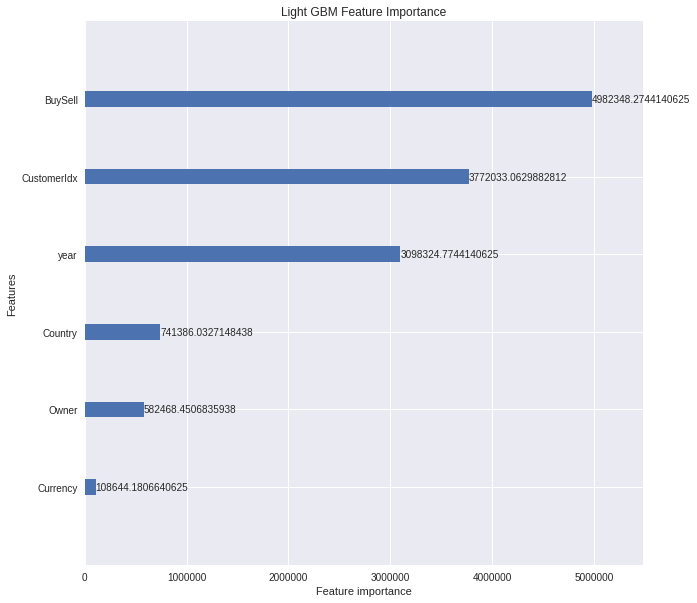

In [21]:
lgb.plot_importance(model_holdings,importance_type='gain',figsize=(10,10))
plt.title("Light GBM Feature Importance")

In [22]:
test = pd.read_csv('Challenge_20180423.csv',parse_dates=['DateKey'])
test = test.rename({'DateKey':'TradeDateKey'},axis=1)
test['BuySell'] = test['BuySell'].astype('category')
test['TradeDateKey'] = '20180423'
test['TradeDateKey'] = pd.to_datetime(test.TradeDateKey)
test['year'] = test.TradeDateKey.dt.year
test['month'] = test.TradeDateKey.dt.month
test['weekofyear'] = test.TradeDateKey.dt.weekofyear
test['BuySell'] = encoder.transform(test['BuySell'].astype(str))
test_13 = test.drop(['TradeDateKey','month','CustomerInterest'],axis=1)
test_13['weekofyear'] = 13
test_14 = test.drop(['TradeDateKey','month','CustomerInterest'],axis=1)
test_14['weekofyear'] = 14
test_15 = test.drop(['TradeDateKey','month','CustomerInterest'],axis=1)
test_15['weekofyear'] = 15
test_16 = test.drop(['TradeDateKey','month','CustomerInterest'],axis=1)
test_16['weekofyear'] = 16
test_local = pd.concat([test_13,test_14,test_15,test_16],axis=0)
del test_13,test_14,test_15,test_16
gc.collect()
test_local = test_local.merge(customer,on=['CustomerIdx'],how='left')
test_local = test_local.merge(bond,on=['IsinIdx'],how='left')
test_local = test_local.merge(trade[valid_index][['CustomerIdx','IsinIdx','BuySell','year','weekofyear','CustomerInterest']],on=['CustomerIdx','IsinIdx','BuySell','year','weekofyear'],how='left')
test_local['CustomerInterest'][test_local.CustomerInterest.isnull()] = False
test_local.head()

/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,PredictionIdx,CustomerIdx,IsinIdx,BuySell,year,weekofyear,Sector,Subsector,CustomerRegion,Country,...,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType,CustomerInterest
0,a1e0d80784,1856,13323,0,2018,13,0,24,0,95,...,3,4,96,9,4,225,7,4.500000e+08,0,False
1,c2cc6cc2a8,1856,9230,0,2018,13,0,24,0,95,...,3,4,87,7,7,194,10,4.000000e+08,0,False
2,a8e94f6344,1780,9157,0,2018,13,0,1,0,95,...,7,22,83,1,9,81,2,3.000000e+08,1,False
3,758bae1e35,2129,9131,0,2018,13,1,25,0,95,...,7,22,83,1,9,81,7,4.000000e+09,0,False
4,02ab378ee8,1758,7151,0,2018,13,0,1,0,95,...,7,24,79,14,12,92,10,3.000000e+08,0,False


In [23]:
test_local['predCustomerInterest'] = model_holdings.predict(test_local.loc[:,predictors_holdings].values)
from sklearn.metrics import roc_auc_score
y_true = test_local.CustomerInterest.astype(int).values
y_scores = test_local.predCustomerInterest.values
roc_auc_score(y_true, y_scores)

0.5355703849562063

In [22]:
test = test.merge(customer,on=['CustomerIdx'],how='left')
test = test.merge(bond,on=['IsinIdx'],how='left')

In [23]:
test['CustomerInterest'] = model_holdings.predict(test.loc[:,predictors_holdings].values)
test.head()

,PredictionIdx,TradeDateKey,CustomerIdx,IsinIdx,BuySell,CustomerInterest,year,month,weekofyear,Sector,...,BondRegion,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType
0,a1e0d80784,2018-04-23,1856,13323,0,0.115904,2018,4,17,0,...,0,3,4,96,9,4,225,7,4.500000e+08,0
1,c2cc6cc2a8,2018-04-23,1856,9230,0,0.122387,2018,4,17,0,...,0,3,4,87,7,7,194,10,4.000000e+08,0
2,a8e94f6344,2018-04-23,1780,9157,0,0.061858,2018,4,17,0,...,0,7,22,83,1,9,81,2,3.000000e+08,1
3,758bae1e35,2018-04-23,2129,9131,0,0.124020,2018,4,17,1,...,0,7,22,83,1,9,81,7,4.000000e+09,0
4,02ab378ee8,2018-04-23,1758,7151,0,0.079705,2018,4,17,0,...,0,7,24,79,14,12,92,10,3.000000e+08,0


In [27]:
test.CustomerInterest.describe()
test[['PredictionIdx','CustomerInterest']].to_csv('submission_sambeet_syntheticlast6months.csv', index=False)

In [25]:
x = pd.read_csv('Submission_LookBack_90Days.csv')

In [26]:
pd.concat([test.CustomerInterest,x.CustomerInterest],axis=1).corr()

,CustomerInterest,CustomerInterest
CustomerInterest,1.000000,0.127917
CustomerInterest,0.127917,1.000000


In [ ]:
test_13 = test.drop(['TradeDateKey','month','CustomerInterest'],axis=1)
test_13['weekofyear'] = 13
test_14 = test.drop(['TradeDateKey','month','CustomerInterest'],axis=1)
test_14['weekofyear'] = 14
test_15 = test.drop(['TradeDateKey','month','CustomerInterest'],axis=1)
test_15['weekofyear'] = 15
test_16 = test.drop(['TradeDateKey','month','CustomerInterest'],axis=1)
test_16['weekofyear'] = 16
test_local = pd.concat([test_13,test_14,test_15,test_16],axis=0)
del test_13,test_14,test_15,test_16
gc.collect()
trade2 = pd.read_csv('Trade.csv',parse_dates=['TradeDateKey'])
trade2['BuySell'] = trade2['BuySell'].astype('category')
trade2['TradeStatus'] = trade2['TradeStatus'].astype('category')
trade2['CustomerInterest'] = trade2['CustomerInterest'].astype('bool')
trade2['year'] = trade2.TradeDateKey.dt.year
trade2['month'] = trade2.TradeDateKey.dt.month
trade2['weekofyear'] = trade2.TradeDateKey.dt.weekofyear
customer = pd.read_csv('Customer.csv')
categorical_columns = ['Sector','Subsector','Region','Country']
for col in categorical_columns:
    customer[col] = customer[col].astype('category')
bond = pd.read_csv('Isin.csv',parse_dates=['ActualMaturityDateKey', 'IssueDateKey'])
categorical_columns = ['Seniority','Currency','ActivityGroup','Region','Activity',
       'RiskCaptain','Owner','CompositeRating','IndustrySector','IndustrySubgroup','MarketIssue','CouponType']
for col in categorical_columns:
    bond[col] = bond[col].astype('category')
customer = customer.rename({'Region':'CustomerRegion'},axis=1)

bond = bond.rename({'Region':'BondRegion'},axis=1)
trade2 = trade2.merge(customer,on=['CustomerIdx'],how='left')
trade2 = trade2.merge(bond,on=['IsinIdx'],how='left')
test = test.merge(customer,on=['CustomerIdx'],how='left')
test = test.merge(bond,on=['IsinIdx'],how='left')
test_local = test_local.merge(customer,on=['CustomerIdx'],how='left')
test_local = test_local.merge(bond,on=['IsinIdx'],how='left')

categorical_to_be_transformed = ['Sector','Subsector','CustomerRegion', 'Country','Seniority','Currency',
                                 'ActivityGroup', 'BondRegion', 'Activity', 'RiskCaptain', 'Owner', 
                                 'CompositeRating', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue','CouponType']
for feature in categorical_to_be_transformed:
    print 'Transforming {}...'.format(feature)
    encoder = LabelEncoder()
    encoder.fit(trade2[feature].append(test[feature]).astype(str))    
    test_local[feature] = encoder.transform(test_local[feature].astype(str))

test_local = test_local.merge(filtered[['CustomerIdx','IsinIdx','BuySell','year','weekofyear','CustomerInterest']],on=['CustomerIdx','IsinIdx','BuySell','year','weekofyear'],how='left')
test_local['CustomerInterest'][test_local.CustomerInterest.isnull()] = 0
test_local.head()